<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/TU_Dortmund/blob/main/Assignment1_MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from io import BytesIO
import zipfile
import os
# Parameters
a = 139
c = 150
m = 1890
x_0 = 485
N = 2000
x = np.arange(N)
x[0] = x_0
u = np.zeros(N)

In [6]:
for i in range (1,N):
  x[i] = (a*x[i-1] + c) % m

In [27]:
# Scaling the x values
def scaling(x,m,N):
    x = np.asarray(x, dtype=float)
    return x / float(m)

In [28]:
u = scaling(x,m,2000)

In [9]:
from scipy import stats

print("Mean =", np.mean(u))
print("Expected mean =", 0.5)
print("Variance =", np.var(u))
print("Expected variance =", 1/12)

ks_stat, ks_p = stats.kstest(u, 'uniform')
print("KS test statistic =", ks_stat)
print("p-value =", ks_p)

Mean = 0.5025171957671958
Expected mean = 0.5
Variance = 0.08294512435087205
Expected variance = 0.08333333333333333
KS test statistic = 0.034558201058201066
p-value = 0.01644533339604913


In [10]:
def lcg(a, c, m, seed, n):
    """Linear Congruential Generator: returns list of x's (integers)."""
    xs = []
    x = seed % m
    for _ in range(n):
        x = (a * x + c) % m
        xs.append(int(x))
    return xs

In [47]:
def lcg_period(a, c, m, seed, max_iter=10_000_000):
    """Estimate period by simulating until first repeat of seed (or until max_iter)."""
    seen = set()
    x = seed % m
    for i in range(1, max_iter+1):
        x = (a * x + c) % m
        if x == seed % m:
            return i
    return None

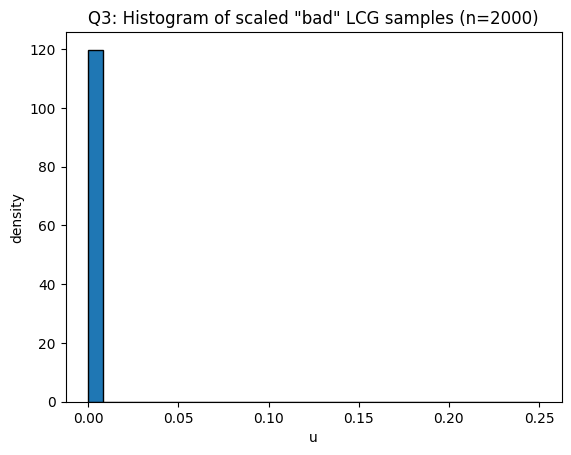

In [51]:
# Q3: "Bad" LCG parameters
# Choose m=1024 (power of 2), a=4, c=0 (multiplicative), seed=1 -> short period due to common factors
m_bad, a_bad, c_bad, x0_bad = 1024, 4, 0, 1
bad_period = lcg_period(a_bad, c_bad, m_bad, x0_bad, max_iter=100000)
x_bad = lcg(a_bad, c_bad, m_bad, x0_bad, 2000)
u_bad = np.array(x_bad, dtype=float) / m_bad

# KS test against U(0,1)
ks_stat, ks_p = stats.kstest(u_bad, 'uniform')

# Plot histogram for Q3
plt.figure()
plt.hist(u_bad, bins=30, density=True, edgecolor='black')
plt.title('Q3: Histogram of scaled "bad" LCG samples (n=2000)')
plt.xlabel('u')
plt.ylabel('density')
hist_q3_path = os.path.join("Q3_bad_lcg_hist.png")
plt.savefig(hist_q3_path, bbox_inches='tight')
plt.show()

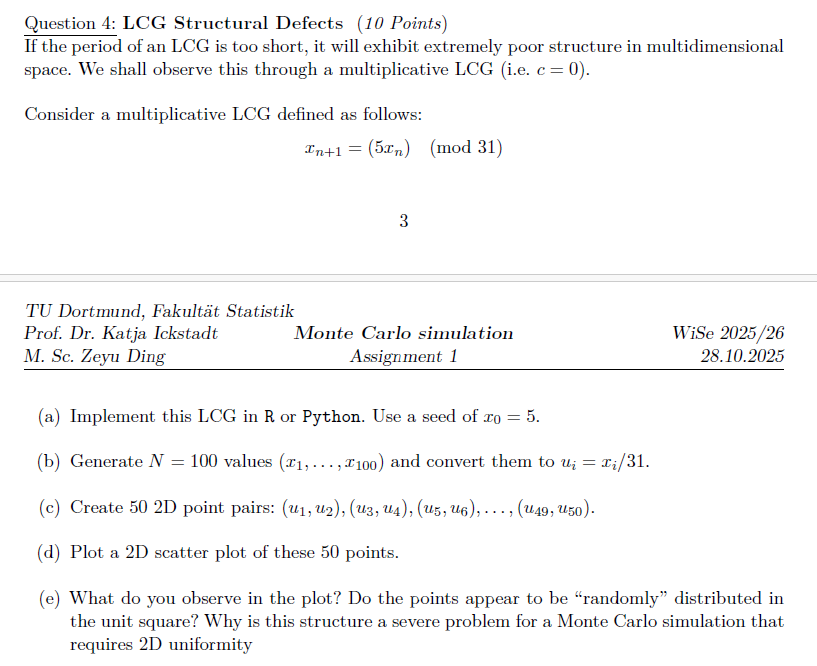

In [29]:
m_q4, a_q4, c_q4, x0_q4 = 31, 5, 0, 5
x_q4 = lcg(a_q4, c_q4, m_q4, x0_q4, 100)
u_q4 = scaling(x_q4,m_q4,100)

# Form 50 pairs (u[0],u[1]), (u[2],u[3]), ..., (u[98],u[99])
pairs = np.column_stack((u_q4[0::2], u_q4[1::2]))

# Sanity check
print(pairs.shape)   # (50, 2)
print(pairs[:5])     # show first 5 pairs

(50, 2)
[[0.80645161 0.03225806]
 [0.16129032 0.80645161]
 [0.03225806 0.16129032]
 [0.80645161 0.03225806]
 [0.16129032 0.80645161]]


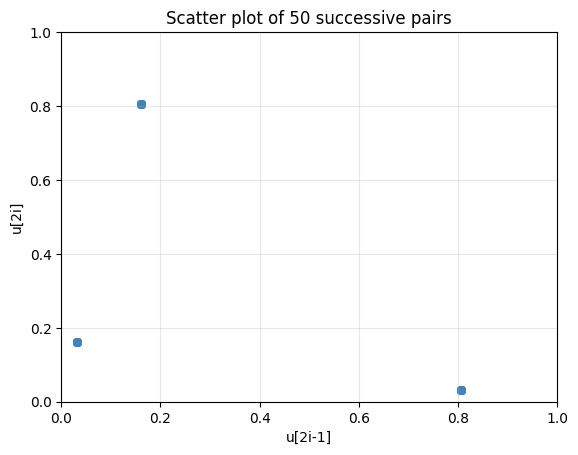

In [32]:
# Plot the pairs in 2D
plt.scatter(pairs[:,0], pairs[:,1], s=30, color='steelblue')
plt.title('Scatter plot of 50 successive pairs')
plt.xlabel('u[2i-1]')
plt.ylabel('u[2i]')
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True, alpha=0.3)
plt.show()